# Chapter 8 Tree-Based Methods Exercises

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
from IPython.display import Image
from io import StringIO
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE, RandomOverSampler

from src import ch8_utils

%matplotlib inline

### 8.2. Why is boosting using depth-one trees (or stumps) analogous to an additive model?

An additive model is one in which each variable is applied its own formula. "Stumped Boosting" more or less performs the same exercise by splitting one feature for each tree.


### 8.5. Ten bootstrapped samples question.

If I use the **majority-vote approach**, the predicted classification is **red**. If I apply **average probability**, the predicted classification is **green**.

In [ ]:
q5_arr = np.array([0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75])
q5_arr.mean()

### 8.5. A detailed explanation of the algorithm that is used to fit a regression tree.

- 

## Conceptual

### 8.7. Create a plot displaying the test error resulting from a random forest on the Boston dataset for a more comprehensive range of values for "max_features" and "n_estimators."

In [ ]:
url_path = os.path.abspath('..')
boston = pd.read_csv(url_path + '/data/Boston.csv')

X = boston.drop('medv', axis=1)
y = boston['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [ ]:
num_trees = np.arange(1, 502, 50)
num_features = np.arange(2, X_train.shape[1], 2)
rf_mse_df = pd.DataFrame(index=num_trees)

for feature_count in num_features:
    mse_tmp_arr = []
    for tree_count in num_trees:
        regr = RandomForestRegressor(n_estimators=tree_count, max_features=feature_count)
        regr.fit(X_train, y_train)
        pred = regr.predict(X_test)
        mse = mean_squared_error(y_test, pred)
        mse_tmp_arr.append(mse)
    
    rf_mse_df[str(feature_count)+ '_features'] = pd.Series(mse_tmp_arr,index=num_trees)

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

sns.lineplot(data=rf_mse_df)
ax.set_title('Random Forest MSE - Boston Test Set', fontsize=16)
ax.set_xlabel('# of Trees')
ax.set_ylabel('MSE')
fig.tight_layout();

The lowest test MSE of **11.072796** was acehieved using **351 estimators** and **6 features**. In general, the models with **>=6 features** performed similary when **>= 51 estimators**. When using 12 features, there seemed to be a bit of overfitting as the MSE increased.

## 8.8. Apply a regression to the Carseats dataset to predict sales.

In [ ]:
url_path = os.path.abspath('..')
carseats = pd.read_csv(url_path + '/data/Carseats.csv')

# Feature engineering
carseats['ShelveLoc'] = pd.factorize(carseats['ShelveLoc'])[0]
carseats['Urban'] = carseats['Urban'].map({'No': 0, 'Yes':1})
carseats['US'] = carseats['US'].map({'No': 0, 'Yes': 1})

carseats.head()

In [ ]:
X = carseats.drop('Sales', axis=1)
y = carseats['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
dtree_regr = DecisionTreeRegressor(max_depth = 5)
dtree_regr.fit(X_train, y_train)
pred = dtree_regr.predict(X_test)

In [ ]:
tree_viz, = ch8_utils.print_tree(dtree_regr, X_train.columns, class_names=None, filled=True)
Image(tree_viz.create_png())

In [ ]:
print('Decision Tree MSE: {:.4}'.format(mean_squared_error(y_test, pred)))

It seems that the sales of carseats is more influenced by adveristing/marketing than product quality/safety. In general, the better the shelve base, the greater the sales. Also, the more affluent the market/consumer - e.g., income and competitive product price - the greater the sales.

In summary, if a company targets the lower economic class, the less goods it is expected to sell

#### Use cross-validation to determine optimal level of tree complexity.

In [ ]:
max_depth_arr = np.arange(1, 11)
avg_train_mse_arr = []
train_cross_val_df = pd.DataFrame()
test_mse_arr = []

for depth in max_depth_arr:
    regr = DecisionTreeRegressor(max_depth=depth)
    regr.fit(X_train, y_train)
    
    # training set metrics
    train_cross_val_arr = -1 * cross_val_score(regr, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    train_cross_val_df[str(depth) + '_depth'] = train_cross_val_arr
    
    train_mse = np.mean(train_cross_val_arr)
    avg_train_mse_arr.append(train_mse)
    
    # test set
    pred = regr.predict(X_test)
    test_mse = mean_squared_error(pred, y_test)
    test_mse_arr.append(test_mse)
    

In [ ]:
train_c_val_df, avg_train_mse_arr, test_mse_arr = ch8_utils.calc_train_test_mse_decision_tree_regr(X_train,
                                                                                                X_test,
                                                                                                y_train,
                                                                                                y_test,
                                                                                                10,
                                                                                                10)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(data=train_c_val_df, ax=ax)
ax.set_title('Decision Tree MSE Distribution (Training Set) by Depth', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

In [ ]:
max_depth_arr = np.arange(1, 11)

fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x=max_depth_arr, y=avg_train_mse_arr, ax=ax)
ax.set_title('Avg Training Set MSE by Decision Tree Complexity', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x=max_depth_arr, y=test_mse_arr, ax=ax)
ax.set_title('Avg Test Set MSE by Decision Tree Complexity', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

A depth of 7 produces the optimal MSE of ~5.6, which is lower than allowing the tree to grow.

### 8.4.d. Apply the previous approach to a bagging model.

In [ ]:
num_features = X.shape[1]

train_c_val_df, avg_train_mse_arr, test_mse_arr = ch8_utils.calc_train_test_mse_bagging_regr(X_train,
                                                                                            X_test,
                                                                                            y_train,
                                                                                                y_test,
                                                                                                10,
                                                                                                10)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(data=train_c_val_df, ax=ax)
ax.set_title('Bagging MSE Distribution (Training Set)by Depth', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

In [ ]:
max_depth_arr = np.arange(1, 11)

fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x=max_depth_arr, y=avg_train_mse_arr, ax=ax)
ax.set_title('Bagging Avg MSE (Training Set) by Depth', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x=max_depth_arr, y=test_mse_arr, ax=ax)
ax.set_title('Bagging MSE (test set) by Depth', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

#### 8.7.d Bagging Feature Importance

Used random forest because bagging is not compatible w/ feature importance.

In [ ]:
# Used ra
#bag_regr = BaggingRegressor()
bag_regr = RandomForestRegressor(max_depth=7,
                                max_features=X_train.shape[1])
bag_regr.fit(X_train, y_train)

pred = bag_regr.predict(X_test)
test_mse = mean_squared_error(pred, y_test)

In [ ]:
feature_importance = pd.DataFrame({'importance': bag_regr.feature_importances_*100}, index=X_train.columns)
feature_importance.sort_values('importance', axis=0, ascending=True, inplace=True)
feature_importance.reset_index()

In [ ]:
ch8_utils.display_bagging_rf_feature_importance(bag_regr, X_train, 'Carseat Bagging Feature Importance', (7,6))

### 8.8.e Apply Random Forest

In [ ]:
# Use GridSearchCV to determine the optimal number of features

rf_regr = RandomForestRegressor()
cv = KFold(n_splits=10, shuffle=True, random_state=3)

# determine optimal number of features per split and depth
grid = dict()
grid['max_features'] = np.arange(2, X_train.shape[0])
grid['max_depth'] = np.arange(1, 7)

gsearch = GridSearchCV(rf_regr, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

results = gsearch.fit(X_train, y_train)

print('Best MSE: {:.5}'.format(results.best_score_))
print('Optimal # of features: {}'.format(results.best_params_['max_features']))
print('Optimal Depth: {}'.format(results.best_params_['max_depth']))

In [ ]:
# Use best parameters to predict carseat sales.
rf_regr = RandomForestRegressor(max_features=8,
                               max_depth=6)

rf_regr.fit(X_train, y_train)
pred = rf_regr.predict(X_test)

print('Test MSE: {:5}'.format(mean_squared_error(y_test, pred)))

In [ ]:
#### Plot the test MSE depending on number of features per split

num_features_arr = np.arange(1, X_train.shape[1])
test_mse_arr = []

for num in num_features_arr:
    rf_regr = RandomForestRegressor(max_features=num)
    rf_regr.fit(X_train, y_train)
    
    pred = rf_regr.predict(X_test)
    
    mse = mean_squared_error(y_test, pred)
    test_mse_arr.append(mse)

In [ ]:
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(num_features_arr, test_mse_arr, c='orange', linewidth=3)
ax.set_title('Random Forest Test MSE', fontsize=16)
ax.set_xlabel('# of Features')
ax.set_ylabel('MSE')

fig.tight_layout();

Overall, the trend of the MSE line slopes downward until it achieves an optimal minimum at **7 fetures**. At which point, MSE begins to increase. I expected such a trend. However, it is odd that there is a spike at 6 features.

In [ ]:
url_path = os.path.abspath('..')
carseats = pd.read_csv(url_path + '/data/Carseats.csv')

## 8.9. OJ Dataset

CH = Citrus Hill <-- 1
<br>
MM = Minute Maid <-- 0

Work requires R.

In [ ]:
url_path = os.path.abspath('..')
oj = pd.read_csv(url_path + '/data/OJ.csv', index_col=0)
oj.head()

#### 8.9.a. Create a training set comprised of 800 random observations.

In [ ]:
oj['STORE'].unique()

In [ ]:
carseats['ShelveLoc'] = pd.factorize(carseats['ShelveLoc'])[0]
carseats['Urban'] = carseats['Urban'].map({'No': 0, 'Yes':1})
carseats['US'] = carseats['US'].map({'No': 0, 'Yes': 1})

In [ ]:
oj['oj_brand'] = oj['Purchase'].map({'CH': 1, 'MM': 0})
oj['Store7'] = oj['Store7'].map({'No': 0, 'Yes': 1})

In [ ]:
X = oj.drop(['oj_brand', 'Purchase'], axis=1)
y = oj['oj_brand']

prcnt_test = 1 - (800 / oj.shape[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=prcnt_test, random_state=3)

#### 8.9.b. Fit a decision treee. Produce summary statistics. What is the training error? How many terminal nodes does the tree have?

In [ ]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
pred = dtree.predict(X_test)

accuracy = accuracy_score(y_test, pred)

('Acc')

---

# 8.10. Use boosting to predict Salary in the Hitters dataset.

In [ ]:
url_path = os.path.abspath('..')
hitters = pd.read_csv(url_path + '/data/Hitters.csv', index_col=0)

hitters.head()

In [ ]:
sns.heatmap(hitters.isnull(), cmap='viridis', cbar=False, yticklabels=False);

In [ ]:
hitters.info()

### Remove null values and log-transform the salaries

In [ ]:
hitters.dropna(axis=0, inplace=True)
hitters['salary_log10'] = np.log10(hitters['Salary'])
hitters['league_is_american'] = hitters['League'].map({'A': 1, 'N': 0})
hitters['new_league_is_american'] = hitters['NewLeague'].map({'A': 1, 'N': 0})
hitters['division_is_east'] = hitters['Division'].map({'E': 1, 'W':0})

hitters.drop(['Salary', 'League', 'NewLeague', 'Division'], axis=1, inplace=True)

In [ ]:
X = hitters.drop('salary_log10', axis=1)
y = hitters['salary_log10']

X_train, X_test = X.iloc[:200, :], X.iloc[200:, :]
y_train, y_test = y.iloc[:200], y.iloc[200:]

In [ ]:
X_train

#### 8.10.c. Perform boosting on the training set w/ 1,000 trees for a range of values of the shrinkage parameter lambda. Produce a plot with different shrinkage values on the x-axis and the corresponding

In [ ]:
lambda_rng = [0.001, 0.01, 0.1, 1]
train_mse_arr = []

for lam in lambda_rng:
    g_boost = GradientBoostingRegressor(n_estimators=1000, learning_rate=lam, random_state=3)
    g_boost.fit(X_train, y_train)
    train_pred = g_boost.predict(X_train)
    train_mse_arr.append(mean_squared_error(y_train, train_pred))

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(lambda_rng, train_mse_arr, c='b', linewidth=3)
ax.set_xscale('log')
ax.set_title('Salary by Shrinkage Rate - Training Set', fontsize=16)
ax.set_xlabel('Lambda')
ax.set_ylabel('MSE')
fig.tight_layout();

### 8.10.d. Perform the above exercise with the test set.

In [ ]:
lambda_rng = [0.001, 0.01, 0.1, 1]
test_mse_arr = []

for lam in lambda_rng:
    g_boost = GradientBoostingRegressor(n_estimators=1000, learning_rate=lam, random_state=3)
    g_boost.fit(X_train, y_train)
    pred = g_boost.predict(X_test)
    test_mse_arr.append(mean_squared_error(y_test, pred))

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(lambda_rng, test_mse_arr, c='b', linewidth=3)
ax.set_xscale('log')
ax.set_title('Salary by Shrinkage Rate - Test Set', fontsize=16)
ax.set_xlabel('Lambda')
ax.set_ylabel('MSE')
fig.tight_layout();

Optimal Gradient Boost Using Training Set Results (for later use)

In [ ]:
gboost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, random_state=3)
gboost.fit(X_train, y_train)
pred = gboost.predict(X_test)
mse = mean_squared_error(y_test, pred)

print('Optimal Gradient Boost MSE (test set): {:.6}'.format(mse))

### 8.10.e. Compare Gradient Boost's test MSE with Linear, Ridge, and Lasso Regression

Linear Regression

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
pred = lin_reg.predict(X_test_scaled)

mse = mean_squared_error(y_test, pred)
print("Linear Regression Test MSE: {:.5}".format(mse))

Ridge Regression

In [ ]:
# Alpha is solely used for Ridge Regression
alphas = 10**np.linspace(10,-2,100)*0.5
cv = KFold(n_splits=10, shuffle=True, random_state=3)

In [ ]:
ridge_cv = RidgeCV(alphas=alphas, cv=cv, fit_intercept=True, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)

print('Ridge CV Best R-Squared (Train set): {:.7}'.format(ridge_cv.best_score_))
print('Best Alpha: {:.6}'.format(ridge_cv.alpha_))

In [ ]:
ridge = Ridge(max_iter=1000)
ridge.set_params(alpha=ridge_cv.alpha_)
ridge.fit(X_train_scaled, y_train)
pred = ridge.predict(X_test_scaled)
mse = mean_squared_error(y_test, pred)

print('Ridge MSE (test set): {:.5}'.format(mse))

Lasso Regression

In [ ]:
lasso_cv = LassoCV(alphas=None, cv=cv, fit_intercept=True)
lasso_cv.fit(X_train_scaled, y_train)

#print('Lasso CV Best R-Squared (train set): {:.7}'.format(lasso_cv.best_score_))
print('Best Alpha: {:.7}'.format(lasso_cv.alpha_))

In [ ]:
lasso = Lasso(max_iter=1000)
lasso.set_params(alpha=lasso_cv.alpha_)
lasso.fit(X_train_scaled, y_train)
pred = lasso.predict(X_test_scaled)

print('Lasso MSE (test set): {:.5}'.format(mean_squared_error(y_test, pred)))

#### 8.10.f. Which variables appear to be the most important predictors in the boosted model?

In [ ]:
salary_boost_results = permutation_importance(gboost, X_test, y_test, n_repeats=10, random_state=3, n_jobs=-1)
perm_importance = pd.DataFrame({'importance': salary_boost_results.importances_mean*100}, index=X_test.columns)
perm_importance.sort_values('importance', axis=0, ascending=True, inplace=True)

In [ ]:
sorted_idx = salary_boost_results.importances_mean.argsort()
perm_importance_2 = pd.DataFrame(salary_boost_results.importances.T *100, columns = X_test.columns)

In [ ]:
sorted_idx = perm_importance_2.median().sort_values().index[::-1]
perm_import_sorted = perm_importance_2[sorted_idx]

In [ ]:


fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=perm_import_sorted, orient='h', ax=ax)
ax.set_xlabel('Importance')
ax.set_title('Permutation Importance', fontsize=18)
fig.tight_layout();

The two most important predictors are a player's number of career at-bats (CAtBat) and the number of career hits (CHits).

#### 8.10.g. Now apply bagging to the training set. What is the best test MSE for this approach?

In [ ]:
num_features = X_train.shape[1]
bagging_regr = RandomForestRegressor(max_features=num_features, random_state=3)
bagging_regr.fit(X_train, y_train)
pred = bagging_regr.predict(X_test)
mse = mean_squared_error(y_test, pred)

print('Bagging MSE (test set): {:.5}'.format(mse))

---
# 8.11. Use the Caravan dataset.

#### 8.11.a. Create a training set consiting of the first 1,000 observations. The test set is comprised of the remaining observations.

In [2]:
url_path = os.path.abspath('..')
caravan = pd.read_csv(url_path + '/data/Caravan.csv')
caravan['Purchase'] = caravan['Purchase'].map({'No': 0, 'Yes':1})
caravan.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


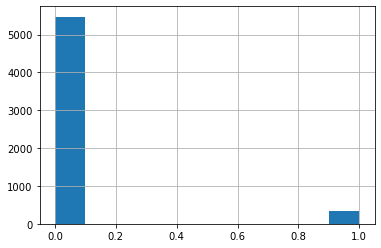

In [3]:
caravan['Purchase'].hist()

In [4]:
prcnt_positive = sum(caravan['Purchase']) / len(caravan['Purchase'])

print('Percent of Positive Obs.: {:.3}'.format(prcnt_positive))                                                 

Percent of Positive Obs.: 0.0598


In [5]:
train_set = caravan.iloc[:1000, :]
test_set = caravan.iloc[1000:, :]


X_train = train_set.drop('Purchase', axis=1)
y_train = train_set['Purchase']

X_test = test_set.drop('Purchase', axis=1)
y_test = test_set['Purchase']

# Oversampling
oversampler = SMOTE(sampling_strategy=0.5)
#oversampler = RandomOverSampler(sampling_strategy=0.5)

X_over, y_over = oversampler.fit_resample(X_train, y_train)


#### 8.11.b. Fit a boosting model to the training set with Purchase as the response and the other variables are predictors. Use 1,000 trees and a shrinkage of 0.01. Which predictors appear to be the most important?

In [6]:
gboost2 = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01)

# NO oversampling
#gboost2.fit(X_train, y_train)

# OVERSAMPLING
gboost2.fit(X_over, y_over)

pred = gboost2.predict(X_test)

print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[4430  103]
 [ 268   21]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4533
           1       0.17      0.07      0.10       289

    accuracy                           0.92      4822
   macro avg       0.56      0.52      0.53      4822
weighted avg       0.90      0.92      0.91      4822



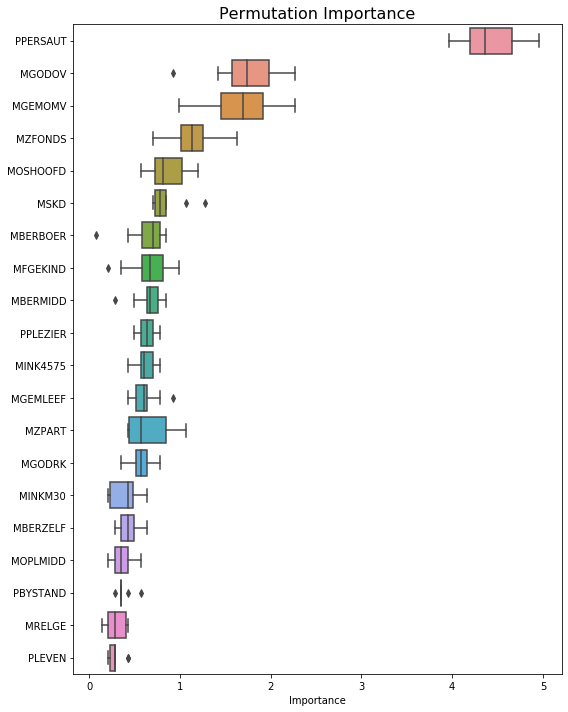

In [7]:
ch8_utils.calculate_and_plot_permutation_importance(gboost2, X_over, y_over, 10, 3, (8,10), 20)

**Most Influencial Features - Permutation Importance:**
<br>
- PPERSAUT Contribution car policies
- MGODOV Other religion
- Avg size household 1 – 6

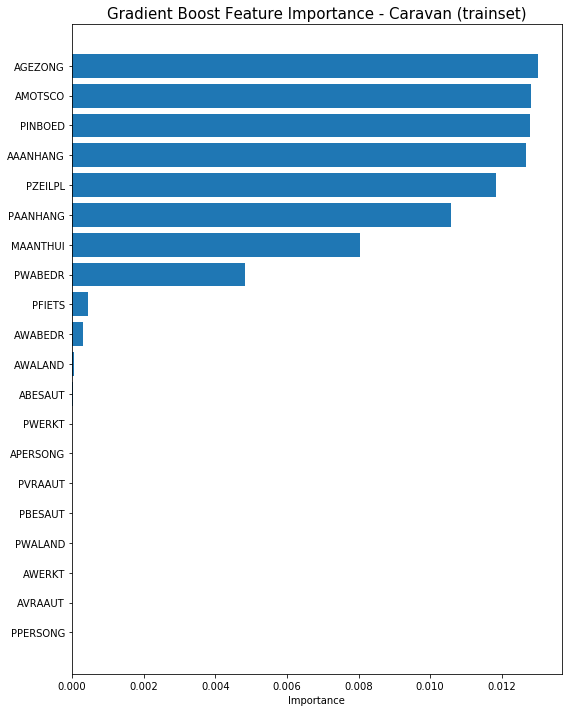

In [8]:
ch8_utils.display_bagging_rf_feature_importance(gboost2,
                                                X_over,
                                                "Gradient Boost Feature Importance - Caravan (trainset)",
                                                (8,10),
                                                20)

**Most Influencial Features - Feature Importance:**
<br>
- AGEZONG 
- AMOTSCO Number of motorcycle/scooter policies
- PINBOED Contribution property insurance policies
- AAANHANG Number of trailer policies
- PZEILPL Contribution surfboard policies
- PAANHANG Contribution trailer policies
- MAANTHUI Number of houses 1 – 10
- PWABEDR Contribution third party insurance (firms) ...